## AlekseevDP(DSU-4, DLL-15)_HW#2_Многослойная НС

Задание: Постройте модель для классификации FashionMNIST. Попробуйте получить качество на тестовой выборке не ниже 88%

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np

In [ ]:
import torchvision as tv
import time

In [ ]:
# зададим размер батча
BATCH_SIZE=256

In [ ]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



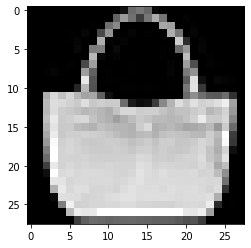

In [ ]:
plt.imshow(train_dataset[100][0].numpy().reshape(28,28), cmap='gray')

In [ ]:
train_dataset[100][0].shape

torch.Size([1, 28, 28])

In [57]:
# запланируем базовый вариант (№1) структуры НС 
torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [64]:
# создадим НС в базовом варианте (№1) 
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
)

In [67]:
loss = torch.nn.CrossEntropyLoss() #зададим кросс-энтропию в качестве функции потерь для многоклассовой (10 классов) классификации.
trainer = torch.optim.SGD(model.parameters(), lr=.01) #возьмем в качестве метода минимизации функции потерь "обычный" стохастический градиентный спуск. Learning rate=0.01
num_epochs = 30

In [68]:
# зададим функцию для обучения модели
def train_model():
  for ep in range(num_epochs):
    train_iters, train_passed  = 0, 0
    train_loss, train_acc = 0., 0.
    start=time.time()
    
    model.train()
    for X, y in train:
        trainer.zero_grad()
        y_pred = model(X)
        l = loss(y_pred, y)
        l.backward()
        trainer.step()
        train_loss += l.item()
        train_acc += (y_pred.argmax(dim=1) == y).sum().item()
        train_iters += 1
        train_passed += len(X)
    
    test_iters, test_passed  = 0, 0
    test_loss, test_acc = 0., 0.
    model.eval()
    for X, y in test:
        y_pred = model(X)
        l = loss(y_pred, y)
        test_loss += l.item()
        test_acc += (y_pred.argmax(dim=1) == y).sum().item()
        test_iters += 1
        test_passed += len(X)
        
    print("ep: {}, taked: {:.3f}, train_loss: {}, train_acc: {}, test_loss: {}, test_acc: {}".format(
        ep, time.time() - start, train_loss / train_iters, train_acc / train_passed,
        test_loss / test_iters, test_acc / test_passed)
    )

In [69]:
train_model()

ep: 0, taked: 7.796, train_loss: 1.752645964825407, train_acc: 0.54775, test_loss: 1.2905839830636978, test_acc: 0.6521
ep: 1, taked: 7.759, train_loss: 1.0740860911125834, train_acc: 0.6727333333333333, test_loss: 0.945449261367321, test_acc: 0.6727
ep: 2, taked: 7.770, train_loss: 0.8628791007589787, train_acc: 0.7031166666666666, test_loss: 0.8187864676117897, test_acc: 0.7068
ep: 3, taked: 7.597, train_loss: 0.7689452062261866, train_acc: 0.7380333333333333, test_loss: 0.7483235716819763, test_acc: 0.7383
ep: 4, taked: 7.487, train_loss: 0.7103876271146409, train_acc: 0.7601333333333333, test_loss: 0.6996238902211189, test_acc: 0.7554
ep: 5, taked: 7.495, train_loss: 0.6677202331258896, train_acc: 0.7769833333333334, test_loss: 0.6629913449287415, test_acc: 0.7719
ep: 6, taked: 7.606, train_loss: 0.6346857172377566, train_acc: 0.7897833333333333, test_loss: 0.634459949284792, test_acc: 0.7821
ep: 7, taked: 7.575, train_loss: 0.6083981766345653, train_acc: 0.79895, test_loss: 0.6117

## Требуемой точности в 88% на тестовой выборке (test_acc) достичь в "базовом" варианте не удалось. Попробуем применить оптимизатор Adam  и снизить LR до 0.001

In [72]:
# Пересоздадим НС в базовом варианте (№1), т.к. иначе обучение продолжается с той же точки (инициализации весов не происходит).
# [Можно было бы написать функцию для обнуления весов модели, но в данном случае проще переинициализировать.]
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
)

In [73]:
loss = torch.nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=.001)
num_epochs = 30

In [74]:
train_model()

ep: 0, taked: 8.057, train_loss: 0.620880563715671, train_acc: 0.7899, test_loss: 0.4964365243911743, test_acc: 0.823
ep: 1, taked: 7.930, train_loss: 0.4316356393885105, train_acc: 0.8492666666666666, test_loss: 0.44634807035326957, test_acc: 0.8408
ep: 2, taked: 8.006, train_loss: 0.3872985488556801, train_acc: 0.8627, test_loss: 0.4149063862860203, test_acc: 0.8524
ep: 3, taked: 8.055, train_loss: 0.35883048677698093, train_acc: 0.8722, test_loss: 0.394533009827137, test_acc: 0.8599
ep: 4, taked: 8.069, train_loss: 0.33749005255546977, train_acc: 0.8787, test_loss: 0.38043092414736746, test_acc: 0.8637
ep: 5, taked: 7.896, train_loss: 0.3198519176625191, train_acc: 0.8846, test_loss: 0.3697623640298843, test_acc: 0.87
ep: 6, taked: 8.785, train_loss: 0.3048764572498646, train_acc: 0.8900666666666667, test_loss: 0.36148560866713525, test_acc: 0.8732
ep: 7, taked: 7.987, train_loss: 0.29207001074831535, train_acc: 0.8938666666666667, test_loss: 0.35451693199574946, test_acc: 0.8737
ep

## Мы видим, что на 18-ой эпохе качество предсказаний на тестовой выборке увеличилось до требуемых 88%, но дальше качество не улучшается (крутится в районе 88%). Попробуем изменить структуру НС.

In [75]:
# добавим дроп-аут 30% перед выходным слоем (вариант модели №2)
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.30), # p – probability of an element to be zeroed. Default: 0.5
    torch.nn.Linear(256, 10)
)


In [76]:
loss = torch.nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=.001)
num_epochs = 30

In [77]:
train_model()

ep: 0, taked: 8.225, train_loss: 0.6577089709170321, train_acc: 0.7764666666666666, test_loss: 0.4864081807434559, test_acc: 0.8257
ep: 1, taked: 8.066, train_loss: 0.4461202990501485, train_acc: 0.84345, test_loss: 0.42418151944875715, test_acc: 0.8463
ep: 2, taked: 8.222, train_loss: 0.39918171256146534, train_acc: 0.85815, test_loss: 0.3926271840929985, test_acc: 0.8603
ep: 3, taked: 8.218, train_loss: 0.36986105010864584, train_acc: 0.8680833333333333, test_loss: 0.37477212138473986, test_acc: 0.8655
ep: 4, taked: 8.338, train_loss: 0.3519387852638326, train_acc: 0.8738833333333333, test_loss: 0.3620991263538599, test_acc: 0.8679
ep: 5, taked: 8.416, train_loss: 0.337193363587907, train_acc: 0.8781333333333333, test_loss: 0.3550729539245367, test_acc: 0.869
ep: 6, taked: 9.613, train_loss: 0.3242391306669154, train_acc: 0.8817, test_loss: 0.3445650853216648, test_acc: 0.8746
ep: 7, taked: 8.377, train_loss: 0.31530496218103043, train_acc: 0.885, test_loss: 0.3372234642505646, test_

## Применение дроп-аута позволило достичь заданной точности в 88% почти вдвое быстрее, чем без дроп-аута (за 11 эпох против 18-и). Далее качество предсказаний увеличилось до 89%. Попробуем ещё улучшить качество, добавив батч-нормализацию.

In [78]:
# вариант модели №3
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.30), # p – probability of an element to be zeroed. Default: 0.5
    torch.nn.Linear(256, 10)
)

In [79]:
loss = torch.nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=.001)
num_epochs = 30

In [80]:
train_model()

ep: 0, taked: 8.574, train_loss: 0.5133187608515962, train_acc: 0.8223666666666667, test_loss: 0.4291722189635038, test_acc: 0.8436
ep: 1, taked: 8.354, train_loss: 0.37972885408300033, train_acc: 0.8637333333333334, test_loss: 0.4011194985359907, test_acc: 0.8534
ep: 2, taked: 8.454, train_loss: 0.3438854343713598, train_acc: 0.8765666666666667, test_loss: 0.3637930929660797, test_acc: 0.8671
ep: 3, taked: 8.815, train_loss: 0.3215250435661762, train_acc: 0.8832166666666666, test_loss: 0.3555392399430275, test_acc: 0.8707
ep: 4, taked: 8.211, train_loss: 0.3051422244690834, train_acc: 0.8898, test_loss: 0.3467036306858063, test_acc: 0.8737
ep: 5, taked: 8.618, train_loss: 0.29033359415987703, train_acc: 0.89435, test_loss: 0.3475345138460398, test_acc: 0.8731
ep: 6, taked: 8.599, train_loss: 0.27720449224431465, train_acc: 0.8986333333333333, test_loss: 0.3299267265945673, test_acc: 0.8801
ep: 7, taked: 8.374, train_loss: 0.265864700649647, train_acc: 0.9022333333333333, test_loss: 0.

## Применение батч-нормализации в данном варианте не привело к увеличению качества предсказаний. Вариант №2 был в данном случае оптимальным, т.е. для увеличения скорости обучения и повышения качества было достаточно дроп-аута. 

## Следует также отметить, что для дальнейшего увеличения качества предсказаний требуются новые эксперименты со структурой НС, причём в качестве метода может быть имеет смысл всё-таки применять SGD (или альтернативу) вместо Adam. Причина - в рассмотренных вариантах на Adam наблюдается значительное переобучение модели (ошибка test_loss в 1.5 - 2 раза выше, чем train_loss). При этом на SGD расхождение трейн- и тест-лосса было незначительным (train_loss: 0.448; test_loss: 0.474).